We start by loading in the relevant vector arrays representing the rates and uncertainties from the Julia calculations I did

I am using two underlying models for photon emission from systems of nuclear matter that are relevant to heavy-ion collisions: the weakly-coupled quark gluon plasma and the hadron gas. The former model is especially useful for high temperatures and the latter for low temperatures. I discuss specific cutoffs in the domain of temperatures later in this notebook. First, let's plot the parametrized fits for each of these models across a wide domain of temperature, regardless of practical validity for now. 

The specific parameters I use to setup my model fits are shown in the report for this submission and in the Julia calculations.

In [1]:
# This cell pulls in the underlying model output from Julia code calculations for further use in this notebook with sklearn's Gaussian Process Regressor
# I work with photon emission in log space for the majority of calculations before going back to real space because it is easier to handle model uncertainties in this way (that are fed into the GP)

import numpy as np

base_path = "/Users/harvir_d/test_qual/"

# Base rates
qgp_rate = np.load(base_path + "qgp_rate.npy")
hadron_gas_rate = np.load(base_path + "hadron_gas_rate.npy")

# Log-scaled rates 
log_qgp_rate = np.load(base_path + "log_qgp_rate.npy")
log_hadron_gas_rate = np.load(base_path + "log_hadron_gas_rate.npy")

# Log uncertainties
log_uncert_qgp = np.load(base_path + "log_uncert_qgp.npy")
log_uncert_hg = np.load(base_path + "log_uncert_hg.npy")

# Real-space uncertainty bounds
qgp_rate_upper = np.load(base_path + "qgp_rate_upper.npy")
qgp_rate_lower = np.load(base_path + "qgp_rate_lower.npy")

hadron_gas_rate_upper = np.load(base_path + "hadron_gas_rate_upper.npy")
hadron_gas_rate_lower = np.load(base_path + "hadron_gas_rate_lower.npy")

# Temperature array
T = np.load(base_path + "T.npy")


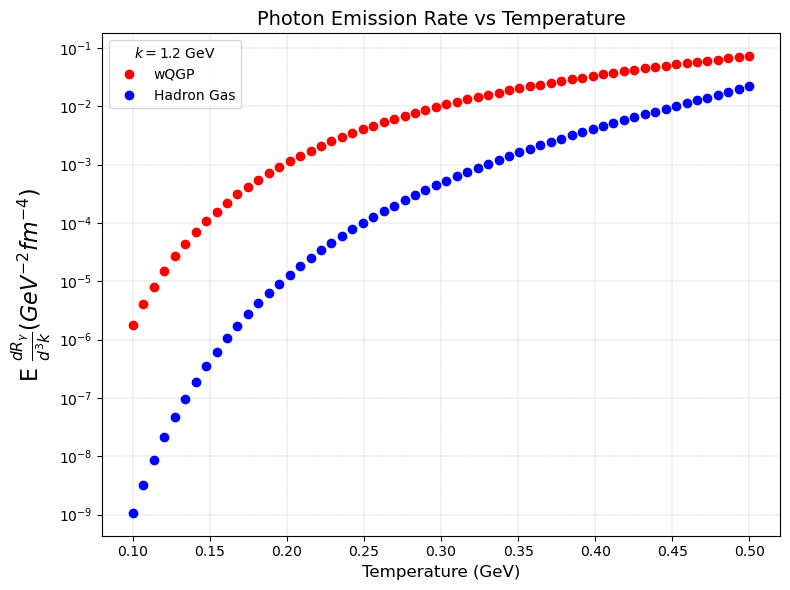

In [29]:
# First, let's see what the model output looks like in real space, no uncertainties applied

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(T, qgp_rate, 'o', color='red', label='wQGP')
plt.plot(T, hadron_gas_rate, 'o', color='blue', label='Hadron Gas')

plt.yscale('log')
plt.xlabel("Temperature (GeV)", fontsize=12)
plt.ylabel(r"E $\frac{dR_\gamma}{d^3k} (GeV^{-2} fm^{-4})$", fontsize=16)
plt.title("Photon Emission Rate vs Temperature", fontsize=14)
plt.tick_params(axis='y', which='minor', length=0)  # Hides secondary (minor) y-axis ticks
plt.legend(title=r"$k = 1.2\ \mathrm{GeV}$")
plt.grid(True, ls="--", linewidth=0.3)
plt.tight_layout()
plt.show()


k is the fixed photon momentum

We notice the wide spread in orders of magnitude on the y-axis. Next, we will transform to log space.

The high and low temperature regions of the above plot (these are not rigid cutoffs and a subject of debate in research, say below 0.25 GeV and above 0.65 GeV respectively) represent systems of nuclear matter that can be aptly described (the photon emission from them) by performing perturbation theory in particular degrees of freedom. For the high T region, these are quarks and gluons. FOr the low T region, these are hadrons. The middle region (once again the actual range is a topic of debate, say 0.25 GeV - 0.65 GeV) is fundamentally a non-perturbative physical system in which we have quasiparticles in strongly-coupled matter. The paramterized fits for either the weakly-coupled QGP (wQGP) or the hadron gas, we do not expect them to be adequately describe the photon emission rate in the middle region. The question is where exactly do they become poor descriptors, and also how they may be nonetheless used in the middle region in place of other models.

In place of the underlying model uncertainties from the wQGP or hadron gas in this project, I will enforce uncertainty behavior in each model that scales according to where the physical degrees of freedom match well or do not match well with what the model was designed for (and the consequent parameterized fit I implemented in Julia) in the first place.

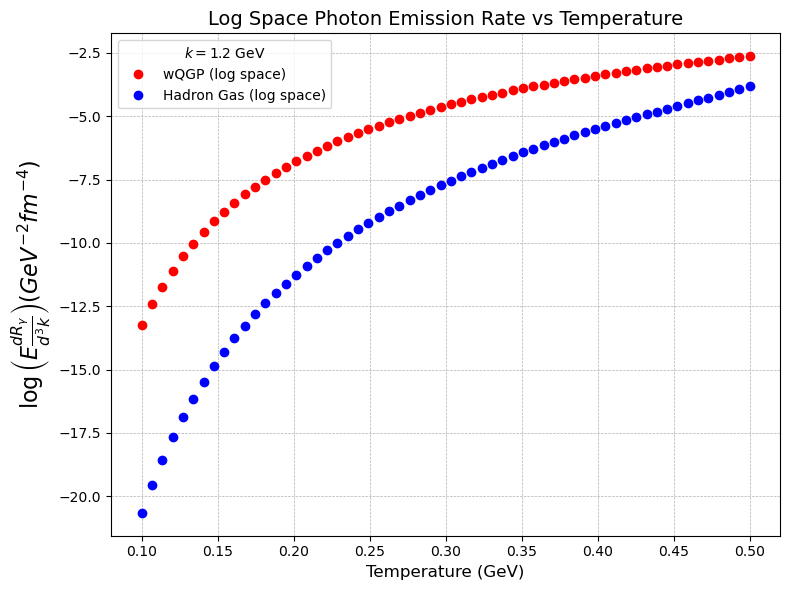

In [3]:
# Let's convert to log space

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(T, log_qgp_rate, 'o', color='red', label='wQGP (log space)')
plt.plot(T, log_hadron_gas_rate, 'o', color='blue', label='Hadron Gas (log space)')

plt.xlabel("Temperature (GeV)", fontsize=12)
plt.ylabel(r"$\log\left(E \frac{dR_\gamma}{d^3k}\right) (GeV^{-2} fm^{-4}) $", fontsize=16)
plt.title("Log Space Photon Emission Rate vs Temperature", fontsize=14)
plt.legend(title=r"$k = 1.2\ \mathrm{GeV}$")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

Now, let's enforce uncertainty behavior across the spectrum for both the qgp and hadron gas, scaling according to their respective confidences for underlying degrees of freedom (quarks and gluons or hadrons).

For the wQGP rate, there is a quantified model uncertainty in next-to-leading-order corrections in the literature (referenced in my report), but I did not have time for the scope of this project to implement them. For the hadron gas, the quantified model uncertainty is much less straightforward in the literature, and it is a part of my summer research to figure out how that works. 

The base values of these rates are estimated from actual fits I did with literature results (referenced in the report), but the uncertainties seen in the next plot are not necessarily reflecting the estimates from literature. Nonetheless, the focus of this project is to see how the behaviors in uncertainty scaling inform the GP for different scenarios, the absolute values of uncertainty are not crucial for this proof of principle. 

The details of the additive factors I used for log space uncertainties and the corresponding uncertainties in real space (once we exponentiate) are found in the Julia code.

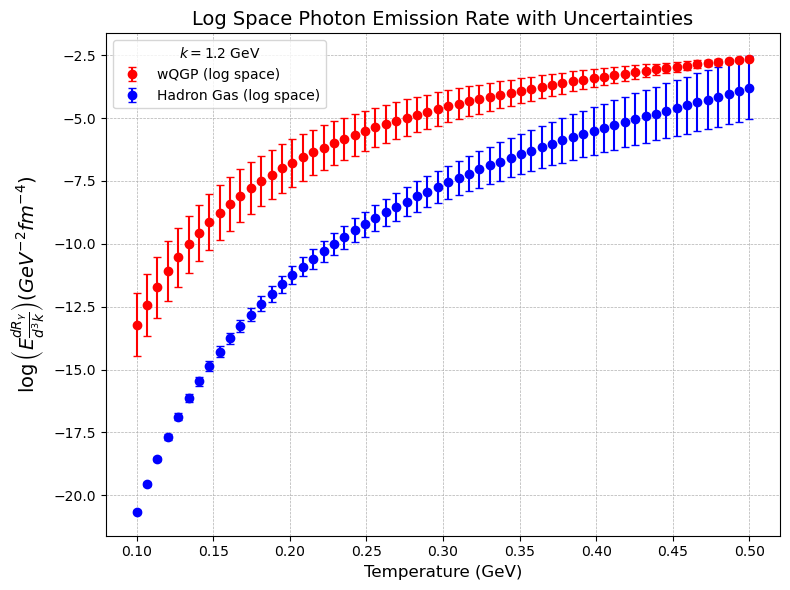

In [30]:
# Plotting rates in log space with uncertainty scaling for each model

plt.figure(figsize=(8, 6))

# QGP: log rate with symmetric log uncertainties, highly confident at large T, vice versa at low T
plt.errorbar(T, log_qgp_rate, yerr=log_uncert_qgp,
             fmt='o', color='red', label='wQGP (log space)', capsize=3)

# Hadron Gas: log rate with symmetric log uncertainties, highly confident at low T, vice versa at high T
plt.errorbar(T, log_hadron_gas_rate, yerr=log_uncert_hg,
             fmt='o', color='blue', label='Hadron Gas (log space)', capsize=3)

plt.xlabel("Temperature (GeV)", fontsize=12)
plt.ylabel(r"$\log\left(E \frac{dR_\gamma}{d^3k}\right) (GeV^{-2} fm^{-4})$", fontsize=14)
plt.title("Log Space Photon Emission Rate with Uncertainties", fontsize=14)
plt.legend(title=r"$k = 1.2\ \mathrm{GeV}$")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

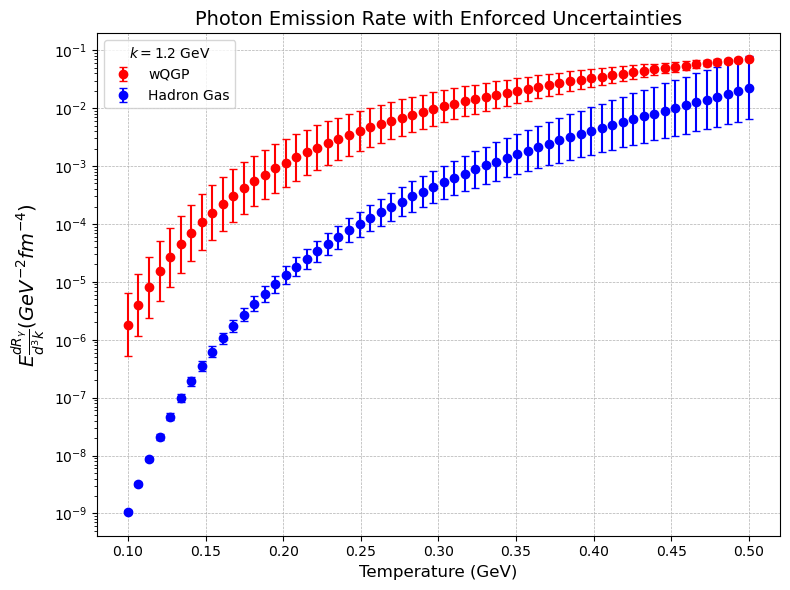

In [33]:
# We can exponentiate the rates and the log space uncertainties to return to real space and see what the uncertainty scaling looks like

plt.figure(figsize=(8, 6))

qgp_err_upper = qgp_rate_upper - qgp_rate
qgp_err_lower = qgp_rate - qgp_rate_lower

plt.errorbar(T, qgp_rate, yerr=[qgp_err_lower, qgp_err_upper],
             fmt='o', color='red', label='wQGP', capsize=3)

hg_err_upper = hadron_gas_rate_upper - hadron_gas_rate
hg_err_lower = hadron_gas_rate - hadron_gas_rate_lower

plt.errorbar(T, hadron_gas_rate, yerr=[hg_err_lower, hg_err_upper],
             fmt='o', color='blue', label='Hadron Gas', capsize=3)

plt.yscale('log')
plt.xlabel("Temperature (GeV)", fontsize=12)
plt.ylabel(r"$E \frac{dR_\gamma}{d^3k} (GeV^{-2} fm^{-4})$", fontsize=14)
plt.title("Photon Emission Rate with Enforced Uncertainties", fontsize=14)
plt.legend(title=r"$k = 1.2\ \mathrm{GeV}$")
plt.grid(True, ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


The model output is now prepped. We can begin with our first "unrefined" GP model, one that we simply feed in (as "observations" or the "data" even though all of this is theoretical model output) the averages of our two models across the entire domain of temperatures. We also feed in simply the combination of uncertainties from the two models as the alpha for the GP. This method is "unrefined" because we are assuming both models are equally weighted in terms of how the GP will handle the underlying model uncertainty.

Later on, we will make a "refined" GP that handles the underlying model uncertainties differently.

We will continue doing the cross-validation and fitting in log space before returning to real space with exponentiation

In [34]:
# Unrefined approach, or equivalently "naive" approach for fitting GP with no insight into the underlying physics

# Compute average log-emission rate, the "observations" for training the GP
log_rate_avg = 0.5 * (log_qgp_rate + log_hadron_gas_rate)

# Compute log-uncertainty used for unrefined training function by doing quadrature 
log_sigma_avg = 0.5 * np.sqrt(log_uncert_qgp**2 + log_uncert_hg**2)

print(log_rate_avg)
print(log_sigma_avg)


[-16.94047813 -15.98884222 -15.14301729 -14.38558773 -13.70279811
 -13.08363621 -12.51917908 -12.00211801 -11.52640762 -11.08700289
 -10.67965926 -10.300779    -9.94729159  -9.61655986  -9.30630547
  -9.0145493   -8.73956342  -8.47983196  -8.23401921  -8.00094324
  -7.7795541   -7.56891559  -7.36819002  -7.17662534  -6.99354423
  -6.81833487  -6.65044293  -6.48936483  -6.33464179  -6.18585475
  -6.04261992  -5.90458489  -5.77142517  -5.64284116  -5.51855546
  -5.39831039  -5.28186582  -5.16899711  -5.05949327  -4.95315514
  -4.84979375  -4.74922863  -4.65128622  -4.55579813  -4.46259952
  -4.37152718  -4.28241762  -4.19510496  -4.10941849  -4.02518014
  -3.94220152  -3.8602807   -3.77919871  -3.69871569  -3.61856692
  -3.53845885  -3.45806532  -3.37702458  -3.29493745  -3.21136755]
[0.62685635 0.6171489  0.60762905 0.59830576 0.58918836 0.58028655
 0.5716104  0.56317034 0.55497716 0.54704193 0.53937604 0.53199114
 0.52489909 0.51811191 0.51164173 0.50550074 0.49970106 0.49425471
 0.489

Right now, the average uncertainties become larger toward either end of our domain, and are still considerable near the middle. This reflects our "unrefined" approach well, and our "refined" approach later on will majorly constrain the uncertainties on the ends because of our physical insights, while the middle will continue to be considerable.

In [35]:
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
random_state = 42

# Reshape T to 2D since sklearn expects input as (n_samples, n_features)
T = T.reshape(-1, 1)

# Split the data into training and testing sets
T_train, T_test, log_rate_train, log_rate_test, log_sigma_train, log_sigma_test = train_test_split(
    T, log_rate_avg, log_sigma_avg, 
    test_size=0.2, 
    random_state=random_state
)

print(T_train)
print(T_test) # confirm this is 6 out of our 30 points

[[0.31016949]
 [0.12033898]
 [0.45254237]
 [0.21525424]
 [0.15423729]
 [0.14067797]
 [0.37118644]
 [0.12711864]
 [0.39152542]
 [0.22881356]
 [0.33050847]
 [0.49322034]
 [0.26949153]
 [0.47966102]
 [0.20169492]
 [0.28305085]
 [0.16101695]
 [0.30338983]
 [0.27627119]
 [0.20847458]
 [0.26271186]
 [0.47288136]
 [0.17457627]
 [0.31694915]
 [0.45932203]
 [0.3779661 ]
 [0.35084746]
 [0.29661017]
 [0.39830508]
 [0.10677966]
 [0.24237288]
 [0.11355932]
 [0.41864407]
 [0.36440678]
 [0.33728814]
 [0.2559322 ]
 [0.43220339]
 [0.16779661]
 [0.24915254]
 [0.2220339 ]
 [0.5       ]
 [0.23559322]
 [0.14745763]
 [0.38474576]
 [0.19491525]
 [0.28983051]
 [0.44576271]
 [0.35762712]]
[[0.1       ]
 [0.13389831]
 [0.3440678 ]
 [0.40508475]
 [0.18813559]
 [0.46610169]
 [0.32372881]
 [0.42542373]
 [0.18135593]
 [0.48644068]
 [0.41186441]
 [0.43898305]]


In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
from sklearn.model_selection import LeaveOneOut
import numpy as np

# Prepare LOOCV
loo = LeaveOneOut()

# Containers for tracking
kernel_bic_scores = {}

# Candidate kernels
kernels = {
    "RBF": C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
    "Matern_1.5": C(1.0, (1e-2, 1e2)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5),
    "Matern_2.5": C(1.0, (1e-2, 1e2)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5),
}

n_train = len(T_train)

for name, kernel in kernels.items():
    # Fit GP on full training set to get final log-likelihood and parameter count
    gp_full = GaussianProcessRegressor(
        kernel=kernel, 
        alpha=log_sigma_train**2, 
        normalize_y=True,
        n_restarts_optimizer=5
    )
    gp_full.fit(T_train, log_rate_train)
    
    # Get log marginal likelihood
    logL = gp_full.log_marginal_likelihood_value_
    
    # Count number of free hyperparameters (signal var, length scale)
    k_params = gp_full.kernel_.n_dims
    
    # Compute BIC
    bic = -2 * logL + k_params * np.log(n_train)
    kernel_bic_scores[name] = bic

# Print BIC scores (lower is better)
for name, bic in kernel_bic_scores.items():
    print(f"{name} BIC: {bic:.2f}")


RBF BIC: 53.00
Matern_1.5 BIC: 53.97
Matern_2.5 BIC: 53.11


These kernels were selected based on a reference to a paper from literature that used multi-fidelity GP modelling but for a hadronic observable calibration rather than photons (to my knowledge, this will be a new approach, the focus of my PhD)

In the complete and comprehensive look at the middle temperature region (which I do not incorporate in this project), I expect that the Matern kernel will be best because there may be many discontinuities in the model output across the domain. I am taking a toy model case for this project where I stretch across the entire domain with two parameterized fits. 

It becomes clear for this project that the more informative trend in the BICs is just the overall difference between the unrefined GP kernels (across them all, regardless of specific choice) and the refined ones, and it is statistically significant. I expect this to be the case because the refined model has constrained underlying uncertainties that are physically motivated. 

In a comprehensive study, I suspect we will see the BICs between choices of kernels may be statistically significant and favor the Matern kernel which can control the smoothness.

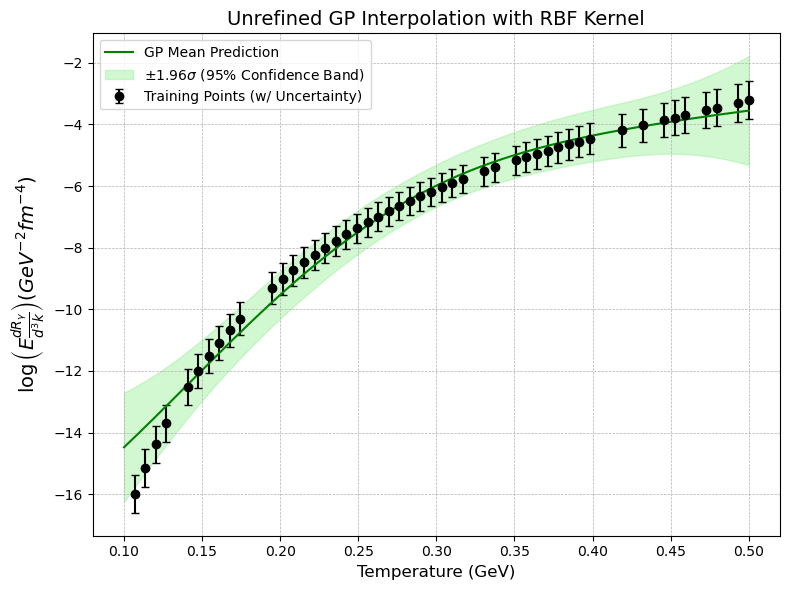

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define the "best" kernel (RBF with sensible bounds)
best_kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Fit optimized GP model on training data
gp = GaussianProcessRegressor(
    kernel=best_kernel,
    alpha=log_sigma_train**2,
    normalize_y=True,
    n_restarts_optimizer=5
)
gp.fit(T_train, log_rate_train)


# Predict on a dense grid for interpolation
T_grid = np.linspace(T.min(), T.max(), 500).reshape(-1, 1)
mean_pred, std_pred = gp.predict(T_grid, return_std=True)

# Plot GP interpolation with 95% confidence band
plt.figure(figsize=(8, 6))

# Training points with vertical error bars
plt.errorbar(
    T_train.flatten(),
    log_rate_train,
    yerr=log_sigma_train,
    fmt='o',
    color='black',
    capsize=3,
    label='Training Points (w/ Uncertainty)'
)

# GP mean prediction
plt.plot(T_grid, mean_pred, '-', color='green', label='GP Mean Prediction')

# 95% confidence interval (1.96 sigma)
plt.fill_between(
    T_grid.flatten(),
    mean_pred - 1.96 * std_pred,
    mean_pred + 1.96 * std_pred,
    color='lightgreen',
    alpha=0.4,
    label=r'$\pm 1.96\sigma$ (95% Confidence Band)'
)

plt.xlabel("Temperature (GeV)", fontsize=12)
plt.ylabel(r"$\log\left(E \frac{dR_\gamma}{d^3k}\right) (GeV^{-2} fm^{-4})$", fontsize=14)
plt.title("Unrefined GP Interpolation with RBF Kernel", fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()



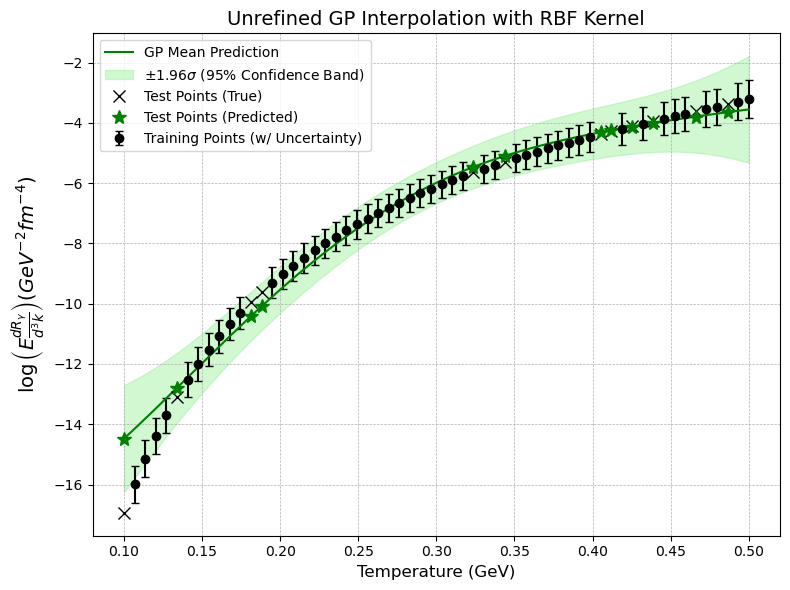

In [38]:
# Repeating GP plot but this time with "true" test set points from split and the predicted test points from the GP


# === GP Setup and Fit ===
best_kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gp = GaussianProcessRegressor(
    kernel=best_kernel,
    alpha=log_sigma_train**2,
    normalize_y=True,
    n_restarts_optimizer=5
)
gp.fit(T_train, log_rate_train)

# === GP Prediction on Interpolation Grid ===
T_grid = np.linspace(T.min(), T.max(), 500).reshape(-1, 1)
mean_pred, std_pred = gp.predict(T_grid, return_std=True)

# === GP Prediction on Test Points ===
mean_test_pred, std_test_pred = gp.predict(T_test, return_std=True)

# === Plotting ===
plt.figure(figsize=(8, 6))

# Training points with uncertainties
plt.errorbar(
    T_train.flatten(),
    log_rate_train,
    yerr=log_sigma_train,
    fmt='o',
    color='black',
    capsize=3,
    label='Training Points (w/ Uncertainty)'
)

# GP interpolation: mean + 95% CI
plt.plot(T_grid, mean_pred, '-', color='green', label='GP Mean Prediction')
plt.fill_between(
    T_grid.flatten(),
    mean_pred - 1.96 * std_pred,
    mean_pred + 1.96 * std_pred,
    color='lightgreen',
    alpha=0.4,
    label=r'$\pm 1.96\sigma$ (95% Confidence Band)'
)

# True test values (ground truth in this case to compare against predictions)
plt.plot(T_test.flatten(), log_rate_test, 'x', color='black', markersize=8, label='Test Points (True)')

# GP-predicted test values
plt.plot(T_test.flatten(), mean_test_pred, '*', color='green', markersize=10, label='Test Points (Predicted)')

plt.xlabel("Temperature (GeV)", fontsize=12)
plt.ylabel(r"$\log\left(E \frac{dR_\gamma}{d^3k}\right) (GeV^{-2} fm^{-4})$", fontsize=14)
plt.title("Unrefined GP Interpolation with RBF Kernel", fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [39]:
# Compute reduced chi-squared in log space for unrefined model
chi_squared_unrefined = np.mean(
    ((log_rate_test - mean_test_pred) / std_test_pred)**2
)

print(f"Unrefined GP Reduced Chi-Squared: {chi_squared_unrefined:.3f}")

Unrefined GP Reduced Chi-Squared: 0.916


I expect that the unrefined chi-square will be larger compared to the refined GP that trains on physically informed insights for the opposing ends of the temperature domain

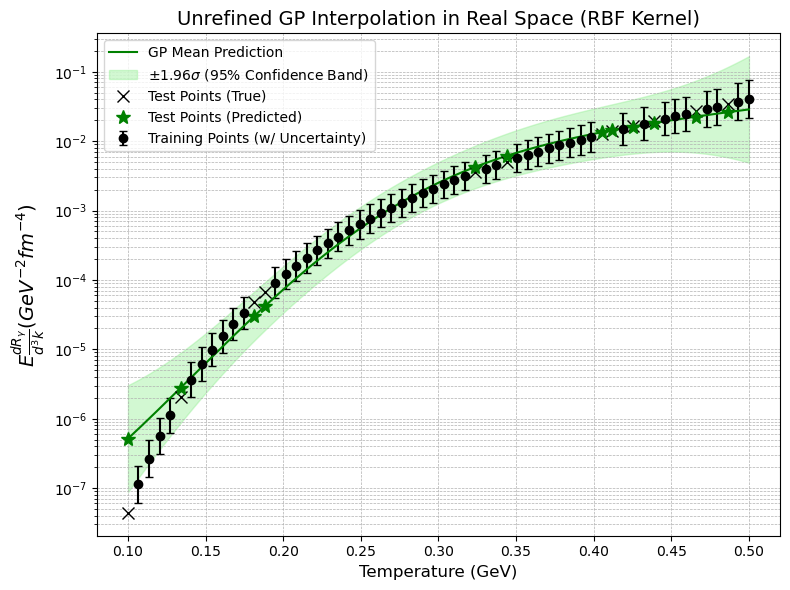

In [40]:
# exponentiating everything to go to real space

# === GP Setup and Fit (RBF) ===
best_kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gp = GaussianProcessRegressor(
    kernel=best_kernel,
    alpha=log_sigma_train**2,
    normalize_y=True,
    n_restarts_optimizer=5
)
gp.fit(T_train, log_rate_train)

# === Predictions in log space ===
T_grid = np.linspace(T.min(), T.max(), 500).reshape(-1, 1)
mean_pred_log, std_pred_log = gp.predict(T_grid, return_std=True)

mean_test_log, std_test_log = gp.predict(T_test, return_std=True)

# === Exponentiate all quantities to real space ===
mean_pred = np.exp(mean_pred_log)
upper_band = np.exp(mean_pred_log + 1.96 * std_pred_log)
lower_band = np.exp(mean_pred_log - 1.96 * std_pred_log)

train_rate_real = np.exp(log_rate_train)
train_err_upper = np.exp(log_rate_train + log_sigma_train) - train_rate_real
train_err_lower = train_rate_real - np.exp(log_rate_train - log_sigma_train)

test_rate_true = np.exp(log_rate_test)
test_rate_pred = np.exp(mean_test_log)

# === Plot ===
plt.figure(figsize=(8, 6))

# Training points with asymmetric error bars
plt.errorbar(
    T_train.flatten(),
    train_rate_real,
    yerr=[train_err_lower, train_err_upper],
    fmt='o',
    color='black',
    capsize=3,
    label='Training Points (w/ Uncertainty)'
)

# GP interpolation in real space
plt.plot(T_grid, mean_pred, '-', color='green', label='GP Mean Prediction')
plt.fill_between(
    T_grid.flatten(),
    lower_band,
    upper_band,
    color='lightgreen',
    alpha=0.4,
    label=r'$\pm 1.96\sigma$ (95% Confidence Band)'
)

# True test points (exponentiated)
plt.plot(T_test.flatten(), test_rate_true, 'x', color='black', markersize=8, label='Test Points (True)')

# Predicted test points (exponentiated)
plt.plot(T_test.flatten(), test_rate_pred, '*', color='green', markersize=10, label='Test Points (Predicted)')

plt.yscale('log')
plt.xlabel("Temperature (GeV)", fontsize=12)
plt.ylabel(r"$E \frac{dR_\gamma}{d^3k} (GeV^{-2} fm^{-4})$", fontsize=14)
plt.title("Unrefined GP Interpolation in Real Space (RBF Kernel)", fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


Let's make our refined GP model.

Out of this, we expect a couple things:
- tight interpolation bands on the ends of the domain, with considerable uncertainty left to the middle region
- the BIC ought to show us an average value across kernels statistically significant (lower) compared to the BICs we just computed because the uncertainty handling on the underlying models benefits from physical insight now.
- the chi square value quantifying the ability for the GP to effectively predict test points to be minimized relative to the unrefined GP

In [41]:
# Define the masks for each region
low_mask = T.flatten() < 0.15 # cutoff for "low T" --> an extension of this project and a comprehensive look in my PhD will include varying choices of cutoffs
mid_mask = (T.flatten() >= 0.15) & (T.flatten() <= 0.4)
high_mask = T.flatten() > 0.4 # cutoff for "high T"

In [58]:

# Preallocate arrays
log_rate_refined = np.empty_like(log_qgp_rate)
log_sigma_refined = np.empty_like(log_uncert_qgp)

# Low-T region: use hadron gas
log_rate_refined[low_mask] = log_hadron_gas_rate[low_mask]
log_sigma_refined[low_mask] = log_uncert_hg[low_mask]

# Mid-T region: use averaged rates and quadrature-averaged uncertainties
log_rate_refined[mid_mask] = 0.5 * (log_qgp_rate[mid_mask] + log_hadron_gas_rate[mid_mask])
log_sigma_refined[mid_mask] = 0.5 * np.sqrt(
    log_uncert_qgp[mid_mask]**2 + log_uncert_hg[mid_mask]**2
)

# High-T region: use QGP
log_rate_refined[high_mask] = log_qgp_rate[high_mask]
log_sigma_refined[high_mask] = log_uncert_qgp[high_mask]


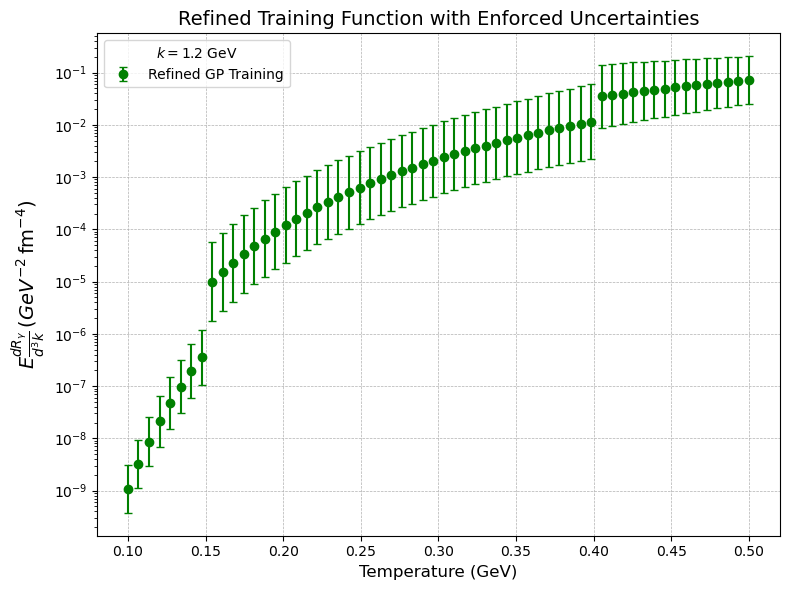

In [62]:
import matplotlib.pyplot as plt

# Exponentiate log-space refined arrays
rate_refined_real = np.exp(log_rate_refined)
sigma_refined_real = np.exp(log_sigma_refined)

# Calculate asymmetric error bars
err_upper = rate_refined_real * (np.exp(sigma_refined_real) - 1)
err_lower = rate_refined_real * (1 - np.exp(-sigma_refined_real))

# Plot
plt.figure(figsize=(8, 6))

plt.errorbar(
    T, rate_refined_real, 
    yerr=[err_lower, err_upper],
    fmt='o', color='green', label='Refined GP Training', capsize=3
)

plt.yscale('log')
plt.xlabel("Temperature (GeV)", fontsize=12)
plt.ylabel(r"$E \frac{dR_\gamma}{d^3k} \, (GeV^{-2}\,\mathrm{fm}^{-4})$", fontsize=14)
plt.title("Refined Training Function with Enforced Uncertainties", fontsize=14)
plt.legend(title=r"$k = 1.2\ \mathrm{GeV}$")
plt.grid(True, ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


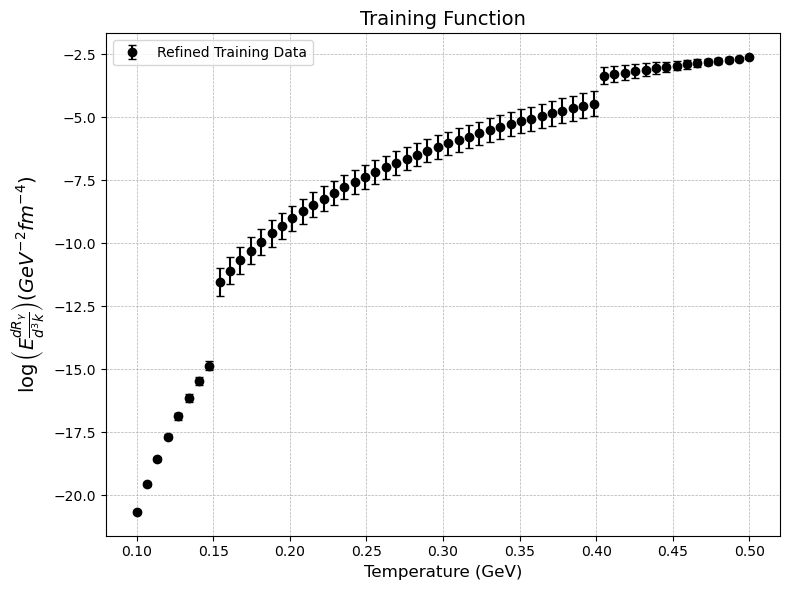

In [59]:

plt.figure(figsize=(8, 6))

# Plot the refined training function with uncertainties
plt.errorbar(
    T.flatten(), 
    log_rate_refined, 
    yerr=log_sigma_refined, 
    fmt='o', 
    color='black', 
    capsize=3, 
    label='Refined Training Data'
)

plt.xlabel("Temperature (GeV)", fontsize=12)
plt.ylabel(r"$\log\left(E \frac{dR_\gamma}{d^3k}\right) (GeV^{-2} fm^{-4})$", fontsize=14)
plt.title("Training Function", fontsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [45]:

# Reshape temperature for sklearn compatibility
T_input = T.reshape(-1, 1)

# Perform the split
T_train_ref, T_test_ref, log_rate_train_ref, log_rate_test_ref, log_sigma_train_ref, log_sigma_test_ref = train_test_split(
    T_input, log_rate_refined, log_sigma_refined,
    test_size=0.2,
    random_state=42
)

In [46]:

# Leave-One-Out cross-validation
loo = LeaveOneOut()

# Define kernel candidates
kernels_refined = {
    "RBF": C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
    "Matern_1.5": C(1.0, (1e-2, 1e2)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5),
    "Matern_2.5": C(1.0, (1e-2, 1e2)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5),
}

n_train_ref = len(T_train_ref)
bic_scores_refined = {}

for name, kernel in kernels_refined.items():
    # Fit GP to full training set (with current kernel)
    gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=log_sigma_train_ref**2,
        normalize_y=True,
        n_restarts_optimizer=5
    )
    gp.fit(T_train_ref, log_rate_train_ref)
    
    # Log marginal likelihood on the full training set
    logL = gp.log_marginal_likelihood_value_
    
    # Number of optimized kernel hyperparameters
    k_params = gp.kernel_.n_dims
    
    # BIC score
    bic = -2 * logL + k_params * np.log(n_train_ref)
    bic_scores_refined[name] = bic

# Display BIC results
for name, bic in bic_scores_refined.items():
    print(f"{name} BIC (refined): {bic:.2f}")


RBF BIC (refined): 25.47
Matern_1.5 BIC (refined): 27.55
Matern_2.5 BIC (refined): 25.96


As expected, the BICs are significantly reduced compared to the unrefined GP

Again, we see negligible statistical significance between kernel choices, but I suspect I might see significance when I include more underlying models in my PhD for the middle temperature regions. Let's go ahead with the Matern 2.5 kernel choice because it is technically the lowest "best" kernel.

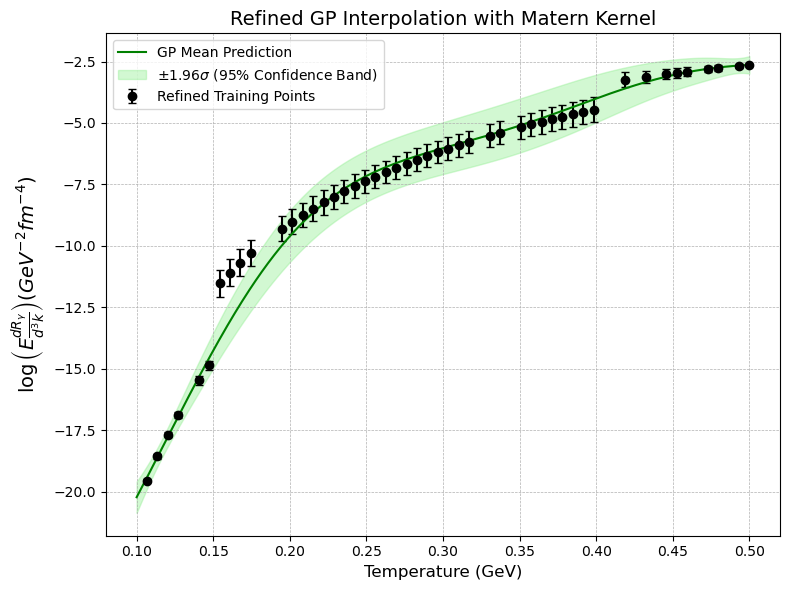

In [47]:

# === Step 1: Define and Fit Refined GP with Matern ν=2.5 ===
best_kernel_refined = C(1.0, (1e-2, 1e2)) * Matern(
    length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5
)

gp_refined = GaussianProcessRegressor(
    kernel=best_kernel_refined,
    alpha=log_sigma_train_ref**2,
    normalize_y=True,
    n_restarts_optimizer=5
)
gp_refined.fit(T_train_ref, log_rate_train_ref)

# === Step 2: Interpolate on Dense Grid ===
T_grid_ref = np.linspace(T.min(), T.max(), 500).reshape(-1, 1)
mean_pred_log_ref, std_pred_log_ref = gp_refined.predict(T_grid_ref, return_std=True)

# === Step 3: Plot Refined GP in Log Space ===
plt.figure(figsize=(8, 6))

# Training data with log uncertainty bars
plt.errorbar(
    T_train_ref.flatten(),
    log_rate_train_ref,
    yerr=log_sigma_train_ref,
    fmt='o',
    color='black',
    capsize=3,
    label='Refined Training Points'
)

# GP mean prediction (log space)
plt.plot(T_grid_ref, mean_pred_log_ref, '-', color='green', label='GP Mean Prediction')

# GP 95% confidence interval (±1.96σ)
plt.fill_between(
    T_grid_ref.flatten(),
    mean_pred_log_ref - 1.96 * std_pred_log_ref,
    mean_pred_log_ref + 1.96 * std_pred_log_ref,
    color='lightgreen',
    alpha=0.4,
    label=r'$\pm 1.96\sigma$ (95% Confidence Band)'
)

plt.xlabel("Temperature (GeV)", fontsize=12)
plt.ylabel(r"$\log\left(E \frac{dR_\gamma}{d^3k}\right) (GeV^{-2} fm^{-4})$", fontsize=14)
plt.title("Refined GP Interpolation with Matern Kernel", fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


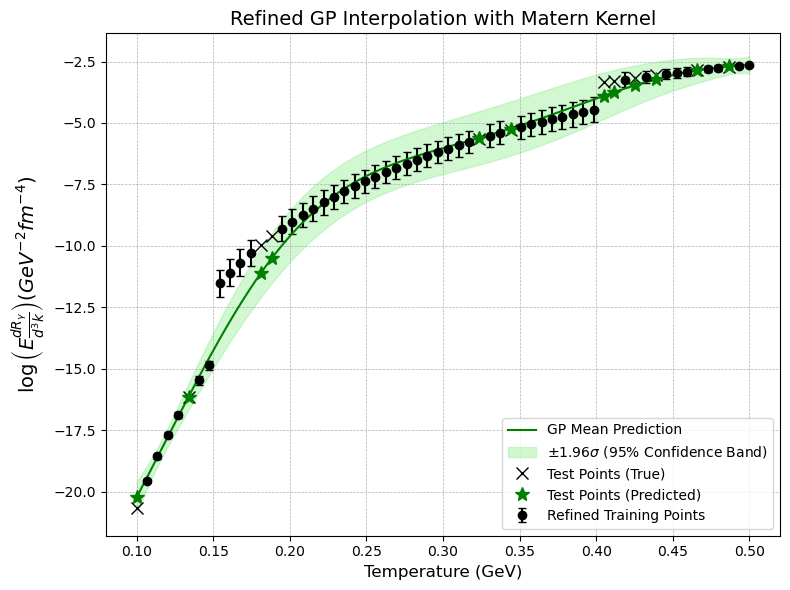

In [48]:

# === Step 1: Define and Fit Refined GP with Matern ν=2.5 ===
best_kernel_refined = C(1.0, (1e-2, 1e2)) * Matern(
    length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5
)

gp_refined = GaussianProcessRegressor(
    kernel=best_kernel_refined,
    alpha=log_sigma_train_ref**2,
    normalize_y=True,
    n_restarts_optimizer=5
)
gp_refined.fit(T_train_ref, log_rate_train_ref)

# === Step 2: GP Prediction on Interpolation Grid and Test Set ===
T_grid_ref = np.linspace(T.min(), T.max(), 500).reshape(-1, 1)
mean_pred_log_ref, std_pred_log_ref = gp_refined.predict(T_grid_ref, return_std=True)

mean_test_log_ref, std_test_log_ref = gp_refined.predict(T_test_ref, return_std=True)

# === Step 3: Plot ===
plt.figure(figsize=(8, 6))

# Training points with uncertainties
plt.errorbar(
    T_train_ref.flatten(),
    log_rate_train_ref,
    yerr=log_sigma_train_ref,
    fmt='o',
    color='black',
    capsize=3,
    label='Refined Training Points'
)

# GP mean prediction (log space)
plt.plot(T_grid_ref, mean_pred_log_ref, '-', color='green', label='GP Mean Prediction')

# 95% confidence band (log space)
plt.fill_between(
    T_grid_ref.flatten(),
    mean_pred_log_ref - 1.96 * std_pred_log_ref,
    mean_pred_log_ref + 1.96 * std_pred_log_ref,
    color='lightgreen',
    alpha=0.4,
    label=r'$\pm 1.96\sigma$ (95% Confidence Band)'
)

# True test points
plt.plot(T_test_ref.flatten(), log_rate_test_ref, 'x', color='black', markersize=8, label='Test Points (True)')

# GP predictions at test points
plt.plot(T_test_ref.flatten(), mean_test_log_ref, '*', color='green', markersize=10, label='Test Points (Predicted)')

plt.xlabel("Temperature (GeV)", fontsize=12)
plt.ylabel(r"$\log\left(E \frac{dR_\gamma}{d^3k}\right) (GeV^{-2} fm^{-4})$", fontsize=14)
plt.title("Refined GP Interpolation with Matern Kernel", fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [20]:
# Compute reduced chi-squared in log space
chi_squared_refined = np.mean(
    ((log_rate_test_ref - mean_test_log_ref) / std_test_log_ref)**2
)

print(f"Refined GP Reduced Chi-Squared: {chi_squared_refined:.3f}")

Refined GP Reduced Chi-Squared: 1.067


As expected, a much lower chi-squared statistic

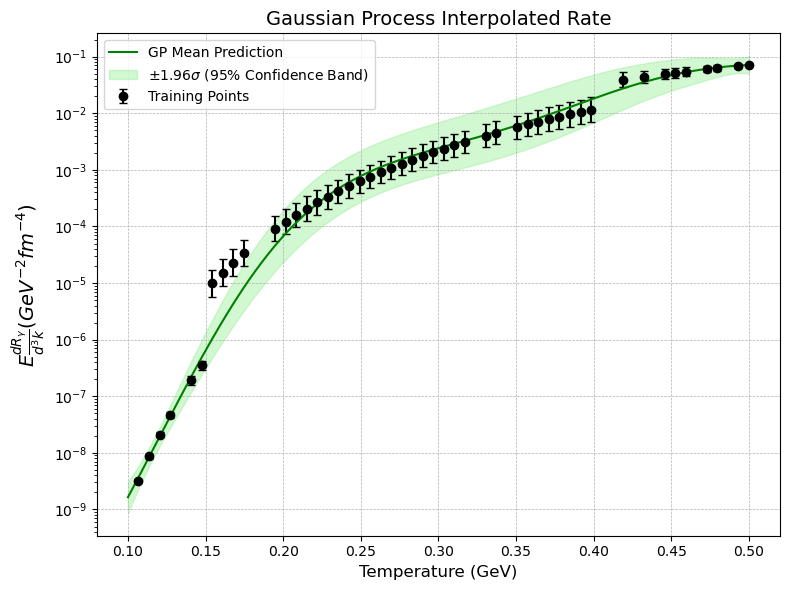

In [52]:

# === Exponentiate predictions and uncertainty bands ===
mean_pred_ref = np.exp(mean_pred_log_ref)
upper_band_ref = np.exp(mean_pred_log_ref + 1.96 * std_pred_log_ref)
lower_band_ref = np.exp(mean_pred_log_ref - 1.96 * std_pred_log_ref)

# Training points (real space)
train_rate_ref_real = np.exp(log_rate_train_ref)
train_err_upper_ref = np.exp(log_rate_train_ref + log_sigma_train_ref) - train_rate_ref_real
train_err_lower_ref = train_rate_ref_real - np.exp(log_rate_train_ref - log_sigma_train_ref)

# Test points: true and predicted (real space)
test_rate_true_ref = np.exp(log_rate_test_ref)
test_rate_pred_ref = np.exp(mean_test_log_ref)

# === Plot ===
plt.figure(figsize=(8, 6))

# Training points with asymmetric error bars
plt.errorbar(
    T_train_ref.flatten(),
    train_rate_ref_real,
    yerr=[train_err_lower_ref, train_err_upper_ref],
    fmt='o',
    color='black',
    capsize=3,
    label='Training Points'
)

# GP mean prediction in real space
plt.plot(T_grid_ref, mean_pred_ref, '-', color='green', label='GP Mean Prediction')

# GP 95% confidence band in real space
plt.fill_between(
    T_grid_ref.flatten(),
    lower_band_ref,
    upper_band_ref,
    color='lightgreen',
    alpha=0.4,
    label=r'$\pm 1.96\sigma$ (95% Confidence Band)'
)

# Test points (true)
#plt.plot(T_test_ref.flatten(), test_rate_true_ref, 'x', color='black', markersize=8, label='Test Points (True)')

# Test points (predicted)
#plt.plot(T_test_ref.flatten(), test_rate_pred_ref, '*', color='green', markersize=10, label='Test Points (Predicted)')

plt.yscale('log')
plt.xlabel("Temperature (GeV)", fontsize=12)
plt.ylabel(r"$E \frac{dR_\gamma}{d^3 k} (GeV^{-2} fm^{-4})$", fontsize=14)
plt.title("Gaussian Process Interpolated Rate", fontsize=14)
plt.legend()
plt.grid(True, ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


This refined approach is closer to matching the reality of what I will be interpolating in my PhD, but of course there is a lot I have left to do. These steps include implementing the underlying model uncertainties, including middle temperature region models like discrete points for the rate from Lattice QCD and continuous (but difficult to validate) model output from Hologrophy AdS/CFT correspondence techniques.

All of this is the photon emission rate, the photon observables will be calculated by integrating the rate (the final interpolated version) over the evolution of the spacetime volume from heavy-ion collision simulations (heavy-ion collisions actually exhibit the temperatures these independent emission rate models work "best" for). 

The observables will then be compared to data to constrain tension between theory and data in terms of counts of photons and other metrics.

I will then design a Gaussian Process Emulator that "cheaply" computes a wide range of parameter choices for my predictions (and it will train on my predictions of photon observables as well as other hadronic observables computed by other groups). This GPE will combine with data from experiment to do a full Bayesian analysis and constrain the heavy-ion collision simulation and potentially constrain my photon emission rate (overarching) itself. 

Tons to do...